<a href="https://colab.research.google.com/github/ash-win19/soccer-analytics/blob/main/Soccer_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import random
import time

# List of popular User-Agent strings to rotate
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:92.0) Gecko/20100101 Firefox/92.0",
    "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
]

# Function to fetch and parse a table from the given URL and table ID
def fetch_table(url, table_id):
    headers = {"User-Agent": random.choice(user_agents)}  # Randomly select a User-Agent
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors
    df = pd.read_html(response.text, attrs={"id": table_id})[0]
    df.columns = df.columns.droplevel() if isinstance(df.columns, pd.MultiIndex) else df.columns
    return df

# Base URLs for the teams
urls_2023_24 = {
    "real_madrid": "https://fbref.com/en/squads/53a2f082/2023-2024/Real-Madrid-Stats",
    "barcelona": "https://fbref.com/en/squads/206d90db/2023-2024/Barcelona-Stats",
    "athletico_madrid": "https://fbref.com/en/squads/db3b9613/2023-2024/Atletico-Madrid-Stats",
    "sevilla": "https://fbref.com/en/squads/ad2be733/2023-2024/Sevilla-Stats"
}

urls_2022_23 = {
    "real_madrid": "https://fbref.com/en/squads/53a2f082/2022-2023/Real-Madrid-Stats",
    "barcelona": "https://fbref.com/en/squads/206d90db/2022-2023/Barcelona-Stats",
    "athletico_madrid": "https://fbref.com/en/squads/db3b9613/2022-2023/Atletico-Madrid-Stats",
    "sevilla": "https://fbref.com/en/squads/ad2be733/2022-2023/Sevilla-Stats"
}

# Table IDs for the stats you want to scrape
table_ids = {
    "stats_standard_12": "Standard Stats",
    "stats_shooting_12": "Shooting Stats",
    "stats_passing_12": "Passing Stats",
    "stats_passing_types_12": "Pass Types",
    "stats_gca_12": "Goal and Shot Creation",
    "stats_defense_12": "Defensive Actions",
    "stats_possession_12": "Possession Stats",
    "stats_playing_time_12": "Playing Time"
}

# Function to fetch data for each team
def fetch_team_data(team, url):
    dataframes = {}
    for table_id, table_name in table_ids.items():
        print(f"Fetching table: {table_name} for {team}...")
        try:
            df = fetch_table(url, table_id)
            df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate columns if any
            dataframes[table_name] = df
            time.sleep(random.uniform(3, 6))  # Random delay between requests (3-6 seconds)
        except Exception as e:
            print(f"Error fetching table {table_name} for {team}: {e}")

    # Initialize master_df with the Standard Stats table
    if "Standard Stats" in dataframes:
        master_df = dataframes["Standard Stats"]
    else:
        print(f"Skipping {team} as Standard Stats table is missing.")
        return None  # Skip if Standard Stats table is missing

    # Merge all tables on the "Player" column with custom suffixes to avoid column name conflicts
    for table_name, df in dataframes.items():
        if table_name != "Standard Stats":
            master_df = master_df.merge(df, on="Player", how="left", suffixes=('', f'_{table_name}'))

    # Add a new column for the team name
    master_df["Team"] = team.replace("_", " ").title()

    # Reorder columns to place the "Team" column next to "Player"
    columns = master_df.columns.tolist()
    player_index = columns.index("Player")
    reordered_columns = columns[:player_index + 1] + ["Team"] + columns[player_index + 1:]
    master_df = master_df[reordered_columns]

    return master_df

# Fetch and save data for each team in 23-24
for team, url in urls_2023_24.items():
    print(f"Processing data for {team}...")
    team_data = fetch_team_data(team, url)

    if team_data is not None:
        # Save the combined DataFrame to a CSV file for this team
        csv_filename = f"{team}_23_24_master_data.csv"
        team_data.to_csv(csv_filename, index=False)
        print(f"Data for {team} saved to '{csv_filename}'.")
    else:
        print(f"Skipping {team} due to missing data.")

# Fetch and save data for each team in 22-23
for team, url in urls_2022_23.items():
    print(f"Processing data for {team}...")
    team_data = fetch_team_data(team, url)

    if team_data is not None:
        # Save the combined DataFrame to a CSV file for this team
        csv_filename = f"{team}_22_23_master_data.csv"
        team_data.to_csv(csv_filename, index=False)
        print(f"Data for {team} saved to '{csv_filename}'.")
    else:
        print(f"Skipping {team} due to missing data.")

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv('/content/Real Madrid Output.csv')
data.head()

# Normalize the features
scaler = StandardScaler()

# Select relevant columns
features = ['Gls', 'Ast', 'G+A', 'Crs', 'xG', 'xAG', 'SoT', 'FK', 'Cmp', 'GCA', 'Tkl']

# Normalize the features
normalized_data = scaler.fit_transform(data[features])


# Create a DataFrame with normalized features
normalized_df = pd.DataFrame(normalized_data, columns=[f'Normalized_{col}' for col in features])

# Calculate the Player Performance Index (PPI)
data['PPI'] = normalized_df.mean(axis=1)

# Save the updated dataset with PPI
data.to_csv('player_stats_with_PPI.csv', index=False)


In [ ]:
# Reference code for PPI plots
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Histogram of PPI
plt.figure(figsize=(8, 6))
sns.histplot(data['PPI'], kde=True, color='blue', bins=20)
plt.title('Distribution of Player Performance Index (PPI)')
plt.xlabel('PPI')
plt.ylabel('Frequency')
plt.show()

# Box Plot for PPI
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['PPI'])
plt.title('PPI Distribution with Outliers')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume 'data' is the dataframe with relevant features and target
X = data[['Age', 'MP', 'xG', 'Ast', 'Min']]  # Features
y = data['Gls']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 5.887090909090909


In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset (replace with the actual path)
data = pd.read_csv("/content/player_stats_with_PPI.csv")  # Replace with your CSV path

# Handle missing values in relevant columns (if any) by dropping them
data = data.dropna(subset=['Age', 'MP', 'xG', 'Ast', 'Min', 'Gls'])

# Creating a categorical target (example: goals-based classification)
data['Performance'] = pd.cut(data['Gls'], bins=[0, 5, 10, float('inf')], labels=['Low', 'Medium', 'High'])

# Remove rows where the 'Performance' column is NaN (if any)
data = data.dropna(subset=['Performance'])

# Features
X = data[['Age', 'MP', 'xG', 'Ast', 'Min']]
y = data['Performance']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         Low       0.75      0.75      0.75         4
      Medium       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



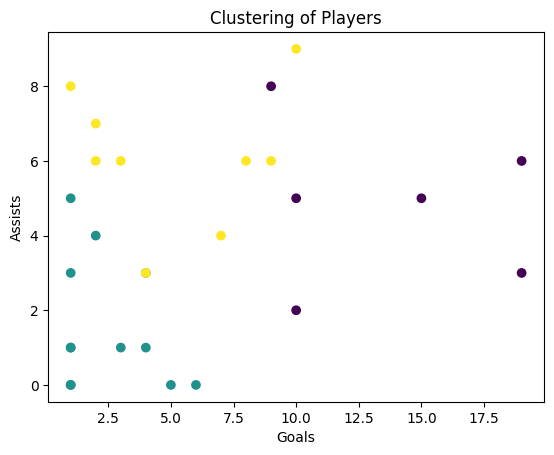

In [25]:
#Clustering: Grouping Similar Players Together
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Feature selection (example)
X = data[['Gls', 'Ast', 'xG', 'MP']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.scatter(data['Gls'], data['Ast'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Goals')
plt.ylabel('Assists')
plt.title('Clustering of Players')
plt.show()


               Player  Gls  Goal_Rank
35      Karim Benzema   19        1.5
3     Jude Bellingham   19        1.5
7     Vinicius Júnior   15        3.0
27    Vinicius Júnior   10        5.0
2             Rodrygo   10        5.0
14             Joselu   10        5.0
32            Rodrygo    9        7.5
43      Marco Asensio    9        7.5
13        Brahim Díaz    8        9.0
30  Federico Valverde    7       10.0


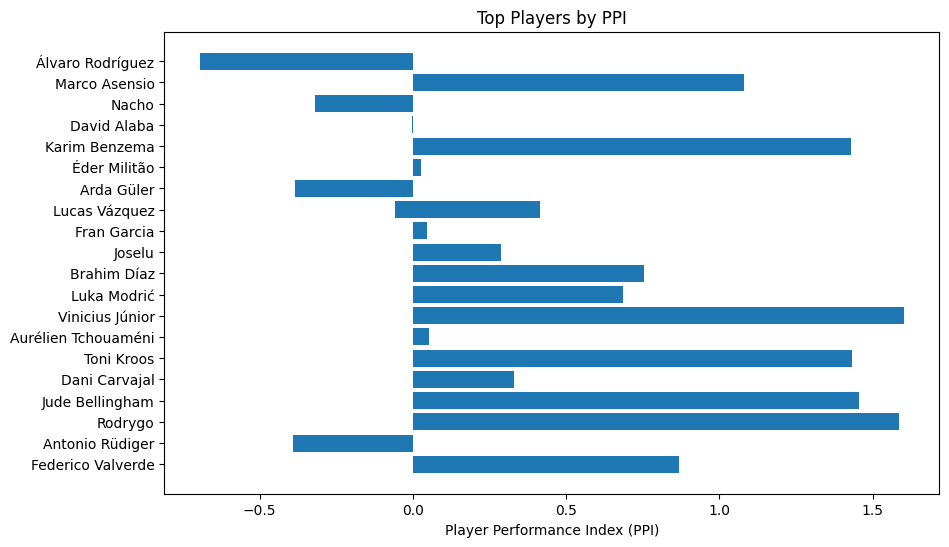

In [27]:
#Ranking: Ranking Players Based on Contribution
# Rank players based on Goals
data['Goal_Rank'] = data['Gls'].rank(ascending=False)

# Rank players based on PPI
data['PPI_Rank'] = data['PPI'].rank(ascending=False)

# View top players by goals
top_players = data[['Player', 'Gls', 'Goal_Rank']].sort_values(by='Goal_Rank').head(10)
print(top_players)

# Visualize rankings
plt.figure(figsize=(10, 6))
plt.barh(data['Player'], data['PPI'])
plt.xlabel('Player Performance Index (PPI)')
plt.title('Top Players by PPI')
plt.show()
